In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score
from IPython.display import clear_output

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './deeplearning_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

Num GPUs Available:  0


2024-06-17 17:15:39.305345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:15:39.335561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Tuning Hyperparameters

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# UnderSampled Set

Test Set
F1 score: 0.06978335233751426
Accuracy score: 0.9590401649475098
Loss score: 0.1361231654882431
Precision score: 0.036316164253501065
Recall score: 0.8895348837209303


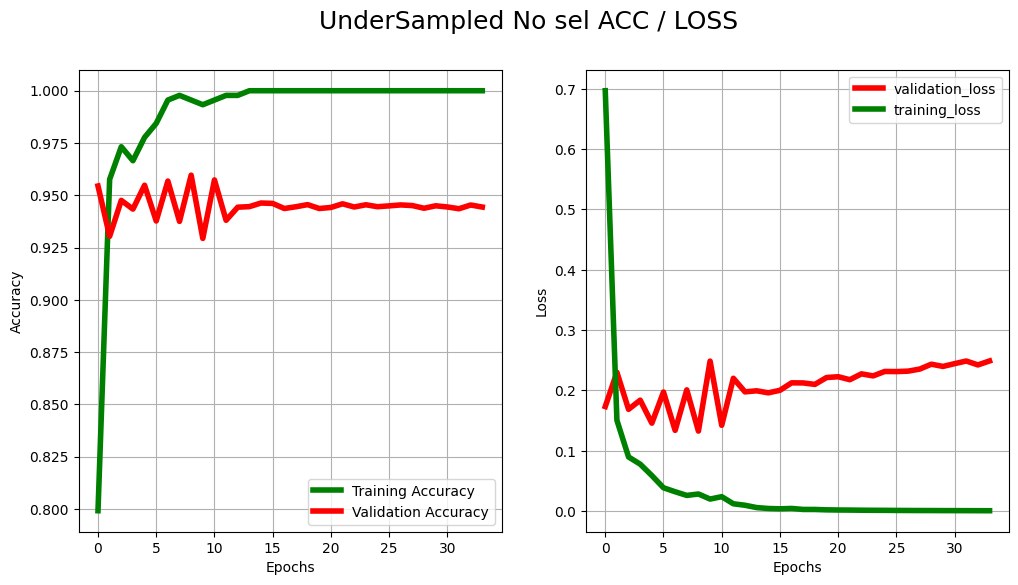

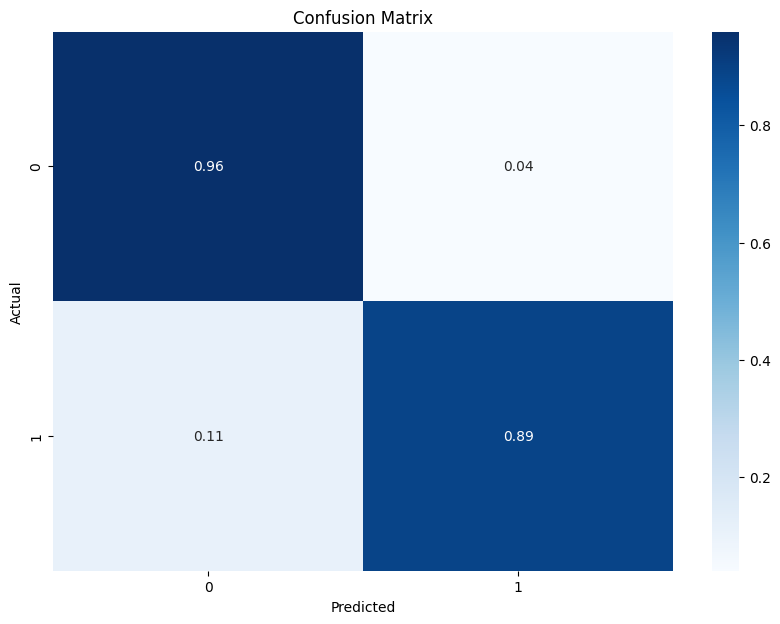

In [17]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_no_sel', exist_ok=True)

model.save(f'{output_dir}/under_no_sel/model.h5')
with open(f'{output_dir}/under_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/under_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
y_pred = model.predict(X_test) > 0.5
y_pred = np.argmax(y_pred, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_test)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)


with open(f'{output_dir}/under_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

with open(f'{output_dir}/under_no_sel/test_scores.json', 'w') as f:
    json.dump({'test_f1': test_f1, 'test_precision': test_precision, 'test_recall': test_recall, 'test_accuracy': test_accuracy}, f)

clear_output()

print("Test Set")
print(f'F1 score: {test_f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {test_precision}')
print(f'Recall score: {test_recall}')


# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', c="green",linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' ,c="red",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# OverSampled Set

In [18]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Test Set
F1 score: 0.7084468664850136
Accuracy score: 0.99892657995224
Loss score: 0.009187925606966019
Precision score: 0.6666666666666666
Recall score: 0.7558139534883721


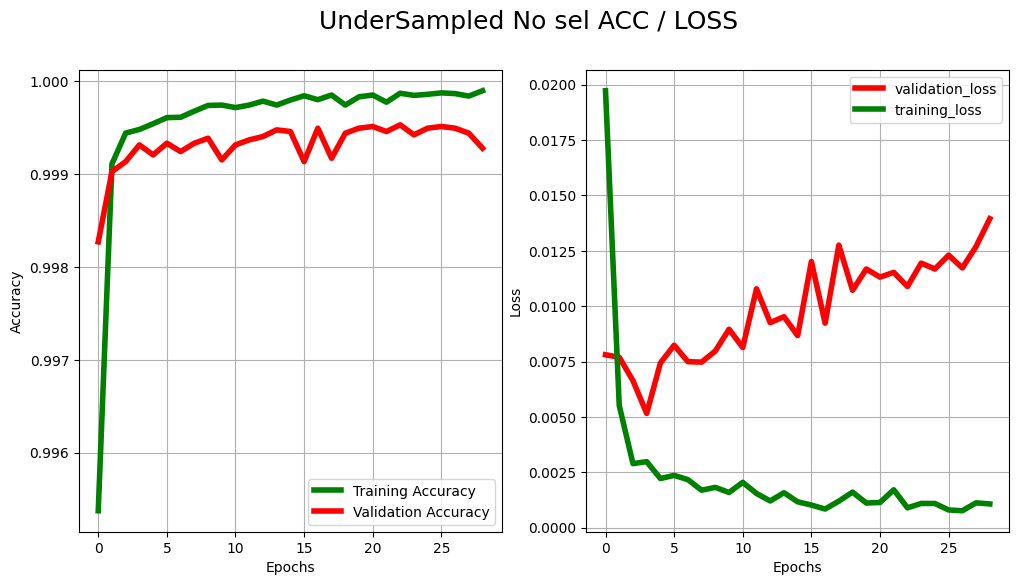

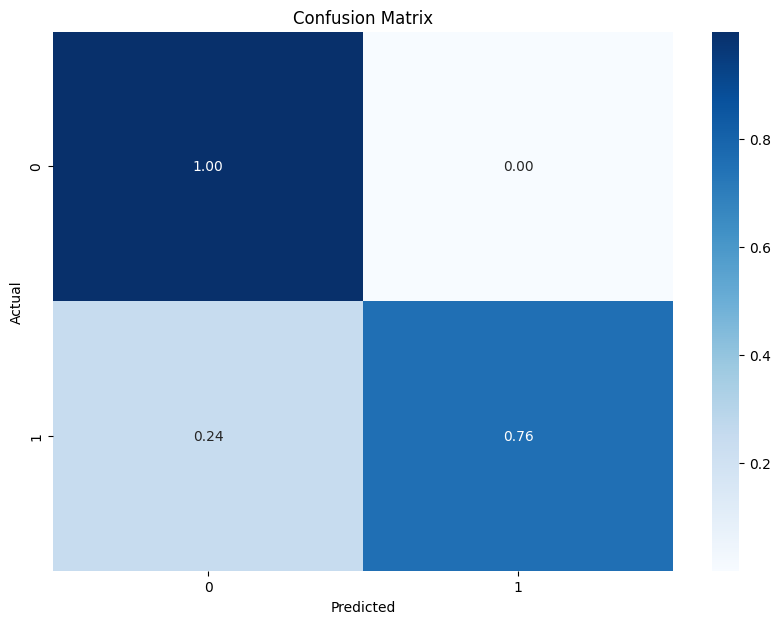

In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_no_sel', exist_ok=True)

model.save(f'{output_dir}/over_no_sel/model.h5')
with open(f'{output_dir}/over_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/over_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
y_pred = model.predict(X_test) > 0.5
y_pred = np.argmax(y_pred, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_test)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

with open(f'{output_dir}/over_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

with open(f'{output_dir}/over_no_sel/test_scores.json', 'w') as f:
    json.dump({'test_f1': test_f1, 'test_precision': test_precision, 'test_recall': test_recall, 'test_accuracy': test_accuracy}, f)

clear_output()

print("Test Set")
print(f'F1 score: {test_f1}')
print(f'Accuracy score: {test_acc}')
print(f'Loss score: {test_loss}')
print(f'Precision score: {test_precision}')
print(f'Recall score: {test_recall}')

# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', c="green",linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' ,c="red",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()